# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60.0K/60.0K [04:39<00:00, 214File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

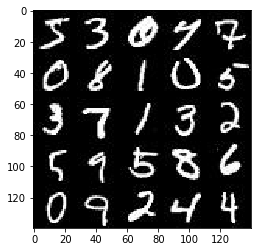

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

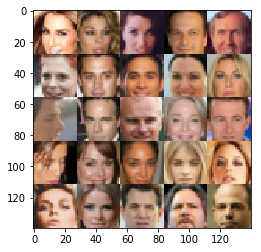

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\ProgramData\Anaconda3\envs\facegeneration\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1

        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha*h1, h1)

        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha*h2, h2)

        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha*h3, h3)

        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1,  (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha*h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha*h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha*h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    img_width, img_height, img_channels = data_shape[1], data_shape[2], data_shape[3]
    real_input, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps=0
    print_every=10
    show_every=100
    losses=[]
    n_images=25
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps+=1
                batch_images*=2.0
                z_sample = np.random.uniform(-1,1,(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input:z_sample, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input:z_sample, lr:learning_rate})
                
                if steps%print_every==0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps%show_every==0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3735... Generator Loss: 0.0682
Epoch 1/2... Discriminator Loss: 0.5320... Generator Loss: 1.9043
Epoch 1/2... Discriminator Loss: 2.2239... Generator Loss: 4.2486
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 2.7957
Epoch 1/2... Discriminator Loss: 0.6328... Generator Loss: 1.3378
Epoch 1/2... Discriminator Loss: 0.3584... Generator Loss: 2.3072
Epoch 1/2... Discriminator Loss: 0.4709... Generator Loss: 2.2418
Epoch 1/2... Discriminator Loss: 0.4519... Generator Loss: 2.3055
Epoch 1/2... Discriminator Loss: 1.7679... Generator Loss: 0.5564
Epoch 1/2... Discriminator Loss: 0.3670... Generator Loss: 2.3610


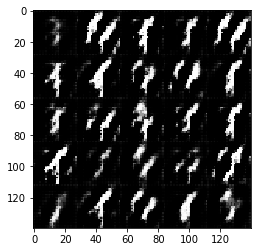

Epoch 1/2... Discriminator Loss: 0.8775... Generator Loss: 5.0371
Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 5.2909
Epoch 1/2... Discriminator Loss: 0.6062... Generator Loss: 1.6804
Epoch 1/2... Discriminator Loss: 0.5211... Generator Loss: 1.6109
Epoch 1/2... Discriminator Loss: 0.8204... Generator Loss: 3.0070
Epoch 1/2... Discriminator Loss: 0.7611... Generator Loss: 1.3232
Epoch 1/2... Discriminator Loss: 0.8238... Generator Loss: 2.9589
Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 2.3221
Epoch 1/2... Discriminator Loss: 2.0634... Generator Loss: 0.4401
Epoch 1/2... Discriminator Loss: 0.6319... Generator Loss: 1.1729


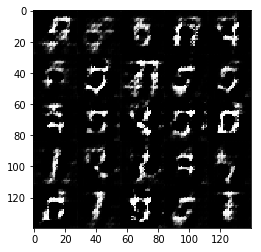

Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 2.0167
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 3.5164
Epoch 1/2... Discriminator Loss: 0.7226... Generator Loss: 1.8418
Epoch 1/2... Discriminator Loss: 1.7211... Generator Loss: 0.3585
Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 0.8641
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 0.9926
Epoch 1/2... Discriminator Loss: 0.9450... Generator Loss: 3.1551
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.3453
Epoch 1/2... Discriminator Loss: 0.8528... Generator Loss: 1.0138
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 2.4633


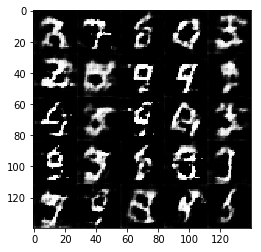

Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 3.0954
Epoch 1/2... Discriminator Loss: 0.5927... Generator Loss: 1.8972
Epoch 1/2... Discriminator Loss: 0.7444... Generator Loss: 2.1672
Epoch 1/2... Discriminator Loss: 0.7853... Generator Loss: 1.9613
Epoch 1/2... Discriminator Loss: 0.8043... Generator Loss: 1.5793
Epoch 1/2... Discriminator Loss: 0.9274... Generator Loss: 2.0304
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.4975
Epoch 1/2... Discriminator Loss: 0.8073... Generator Loss: 1.0296
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 1.3863
Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 0.9468


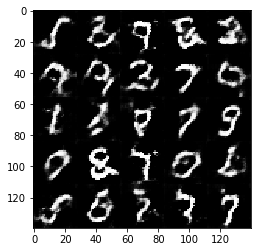

Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 2.9242
Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 2.4060
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 1.9879
Epoch 1/2... Discriminator Loss: 0.8796... Generator Loss: 0.8299
Epoch 1/2... Discriminator Loss: 0.6659... Generator Loss: 2.1832
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.4099
Epoch 1/2... Discriminator Loss: 0.9585... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 0.8682... Generator Loss: 1.4004
Epoch 1/2... Discriminator Loss: 0.7669... Generator Loss: 1.0549


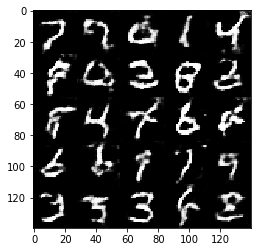

Epoch 1/2... Discriminator Loss: 1.1057... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 1.6013... Generator Loss: 0.3389
Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 2.3448
Epoch 1/2... Discriminator Loss: 0.7402... Generator Loss: 1.2327
Epoch 1/2... Discriminator Loss: 0.7427... Generator Loss: 2.6549
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 2.2814
Epoch 1/2... Discriminator Loss: 0.7695... Generator Loss: 1.5690
Epoch 1/2... Discriminator Loss: 1.6704... Generator Loss: 3.7824
Epoch 1/2... Discriminator Loss: 0.8316... Generator Loss: 0.9681
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 2.5136


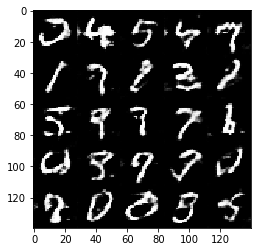

Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 1.6381
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 0.4035
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 0.7494... Generator Loss: 1.4145
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 1.3238
Epoch 1/2... Discriminator Loss: 0.7739... Generator Loss: 1.2600
Epoch 1/2... Discriminator Loss: 0.9438... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.4319
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.6197


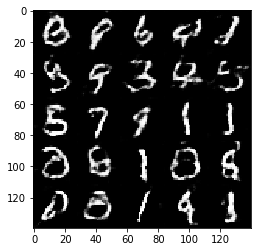

Epoch 1/2... Discriminator Loss: 0.8874... Generator Loss: 0.9050
Epoch 1/2... Discriminator Loss: 1.0434... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 1.3794
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 1.1897
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 1.5744
Epoch 1/2... Discriminator Loss: 0.8309... Generator Loss: 0.9734
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 1.7990
Epoch 1/2... Discriminator Loss: 0.8234... Generator Loss: 1.0770
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 1.1807
Epoch 1/2... Discriminator Loss: 1.6151... Generator Loss: 0.3860


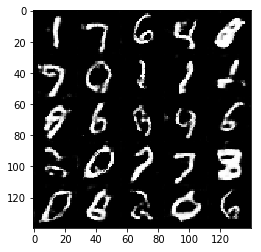

Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 1.0466
Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.6146... Generator Loss: 0.3833
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 4.6466
Epoch 1/2... Discriminator Loss: 0.5924... Generator Loss: 1.8557
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 0.4868
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 1.2708
Epoch 1/2... Discriminator Loss: 0.6262... Generator Loss: 1.5624
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 0.9056


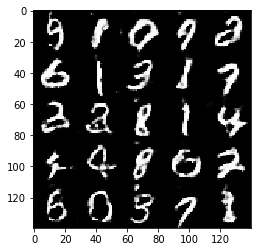

Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.6415
Epoch 1/2... Discriminator Loss: 0.9828... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.0023... Generator Loss: 0.7032
Epoch 2/2... Discriminator Loss: 0.9898... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.4137
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.4499
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 0.8986
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 2.5023
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 0.6413
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 0.7512


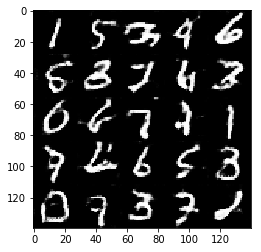

Epoch 2/2... Discriminator Loss: 0.7217... Generator Loss: 1.8065
Epoch 2/2... Discriminator Loss: 0.7008... Generator Loss: 2.0025
Epoch 2/2... Discriminator Loss: 0.5089... Generator Loss: 1.4200
Epoch 2/2... Discriminator Loss: 0.8102... Generator Loss: 0.8734
Epoch 2/2... Discriminator Loss: 1.1016... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 0.7558... Generator Loss: 3.2773
Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 2.1676
Epoch 2/2... Discriminator Loss: 1.6112... Generator Loss: 2.8503
Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 2.8056
Epoch 2/2... Discriminator Loss: 0.5283... Generator Loss: 1.6120


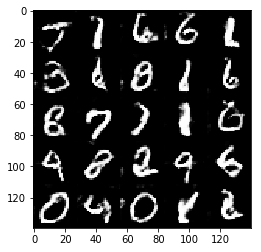

Epoch 2/2... Discriminator Loss: 0.4821... Generator Loss: 1.5995
Epoch 2/2... Discriminator Loss: 0.5280... Generator Loss: 1.7559
Epoch 2/2... Discriminator Loss: 0.4403... Generator Loss: 2.6463
Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 3.6678
Epoch 2/2... Discriminator Loss: 1.4639... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 0.9429... Generator Loss: 1.2000
Epoch 2/2... Discriminator Loss: 0.8594... Generator Loss: 1.0035
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.4609
Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 1.3038
Epoch 2/2... Discriminator Loss: 0.6684... Generator Loss: 1.2131


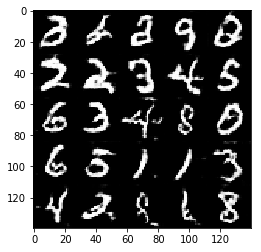

Epoch 2/2... Discriminator Loss: 0.9399... Generator Loss: 0.7895
Epoch 2/2... Discriminator Loss: 0.5636... Generator Loss: 3.0393
Epoch 2/2... Discriminator Loss: 2.0236... Generator Loss: 0.2806
Epoch 2/2... Discriminator Loss: 1.9934... Generator Loss: 0.2510
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 0.9038
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 0.9121
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.5267
Epoch 2/2... Discriminator Loss: 0.6323... Generator Loss: 1.1656
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.0182
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 3.0245


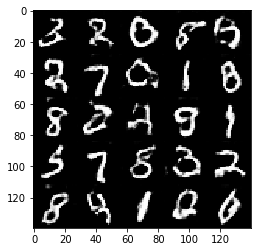

Epoch 2/2... Discriminator Loss: 1.1131... Generator Loss: 0.5889
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 4.2225
Epoch 2/2... Discriminator Loss: 0.6359... Generator Loss: 1.4752
Epoch 2/2... Discriminator Loss: 1.8134... Generator Loss: 0.2817
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 2.3166
Epoch 2/2... Discriminator Loss: 0.5711... Generator Loss: 1.7978
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 3.3072
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 1.1001
Epoch 2/2... Discriminator Loss: 0.7213... Generator Loss: 2.3950


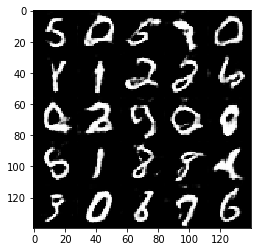

Epoch 2/2... Discriminator Loss: 0.9308... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 1.3278... Generator Loss: 0.4799
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.5814
Epoch 2/2... Discriminator Loss: 0.2041... Generator Loss: 2.4497
Epoch 2/2... Discriminator Loss: 2.6703... Generator Loss: 0.2491
Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 0.6061
Epoch 2/2... Discriminator Loss: 0.5612... Generator Loss: 1.4644
Epoch 2/2... Discriminator Loss: 0.4985... Generator Loss: 1.5262
Epoch 2/2... Discriminator Loss: 0.8070... Generator Loss: 1.1611


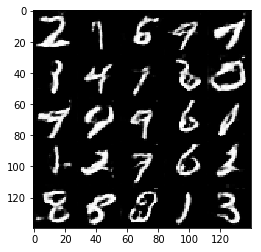

Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 0.9772
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.4924
Epoch 2/2... Discriminator Loss: 0.4119... Generator Loss: 1.7071
Epoch 2/2... Discriminator Loss: 0.2478... Generator Loss: 2.9448
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 1.1971
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 4.2424
Epoch 2/2... Discriminator Loss: 2.2090... Generator Loss: 0.2206
Epoch 2/2... Discriminator Loss: 0.6977... Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 0.9041... Generator Loss: 0.8754
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.0820


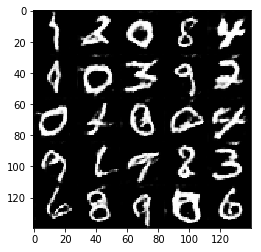

Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 1.1010
Epoch 2/2... Discriminator Loss: 1.0105... Generator Loss: 0.6975
Epoch 2/2... Discriminator Loss: 0.5573... Generator Loss: 1.8591
Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 1.0224
Epoch 2/2... Discriminator Loss: 0.9260... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 1.0956... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 0.8977... Generator Loss: 0.9262
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 1.4693
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.4970
Epoch 2/2... Discriminator Loss: 1.9311... Generator Loss: 0.2739


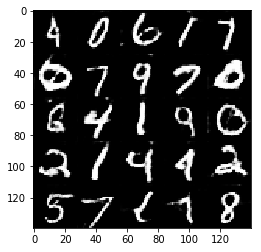

Epoch 2/2... Discriminator Loss: 0.2926... Generator Loss: 2.3375
Epoch 2/2... Discriminator Loss: 1.4842... Generator Loss: 0.4648
Epoch 2/2... Discriminator Loss: 0.4762... Generator Loss: 2.0453
Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 0.9397
Epoch 2/2... Discriminator Loss: 0.5749... Generator Loss: 2.4449
Epoch 2/2... Discriminator Loss: 0.1485... Generator Loss: 3.3275
Epoch 2/2... Discriminator Loss: 0.3265... Generator Loss: 1.9121
Epoch 2/2... Discriminator Loss: 1.8297... Generator Loss: 0.4174
Epoch 2/2... Discriminator Loss: 0.4652... Generator Loss: 1.6709
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 0.8140


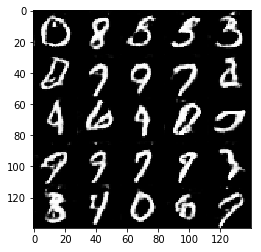

Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 0.9220
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 1.2958
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 0.7502
Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 0.6010
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 0.9777
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 0.7489


In [19]:
batch_size = 64
z_dim = 120
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 10.0676
Epoch 1/1... Discriminator Loss: 0.3330... Generator Loss: 8.5640
Epoch 1/1... Discriminator Loss: 0.7048... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 2.0282
Epoch 1/1... Discriminator Loss: 1.8551... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 2.3326
Epoch 1/1... Discriminator Loss: 1.7601... Generator Loss: 0.2835
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 3.3824


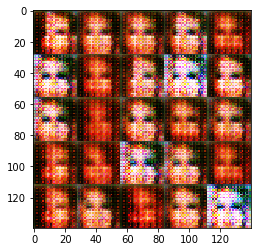

Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 0.4367... Generator Loss: 4.2778
Epoch 1/1... Discriminator Loss: 2.9545... Generator Loss: 0.4308
Epoch 1/1... Discriminator Loss: 0.7726... Generator Loss: 1.6532
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.7603... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 1.9864... Generator Loss: 0.2095
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 2.2498


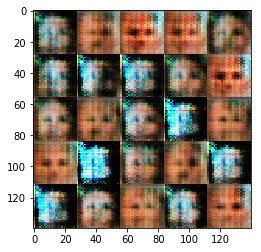

Epoch 1/1... Discriminator Loss: 2.4776... Generator Loss: 0.1639
Epoch 1/1... Discriminator Loss: 2.2130... Generator Loss: 3.7420
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.5574
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.7774... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 2.8490... Generator Loss: 3.7257
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 0.7434


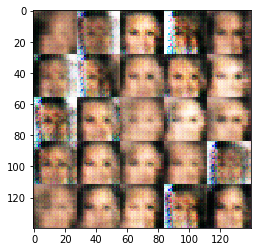

Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.4279
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 1.9078... Generator Loss: 1.6711
Epoch 1/1... Discriminator Loss: 1.5439... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.8502


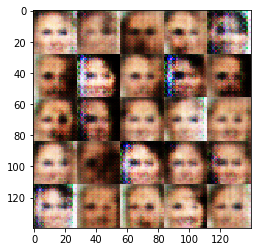

Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 1.4649
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.4001
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.9370


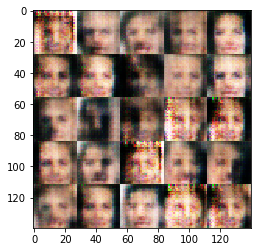

Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 1.9671... Generator Loss: 2.1359
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 1.7085
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.3667
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.9768


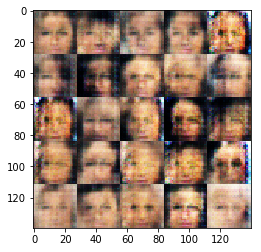

Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 2.3125... Generator Loss: 2.7105
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.5005


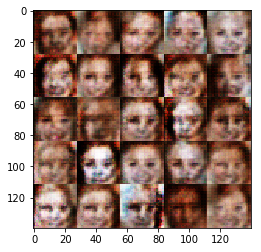

Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.6329


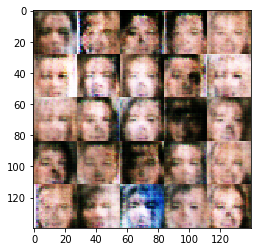

Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 2.1383
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 2.1336
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.5933... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.2187


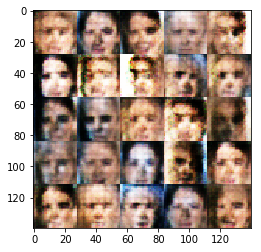

Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 1.6337... Generator Loss: 0.3373
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.6679... Generator Loss: 2.2432
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.3456


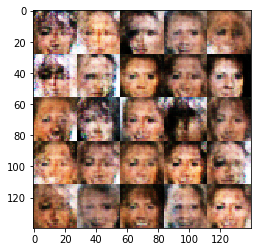

Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 1.9094
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.6601


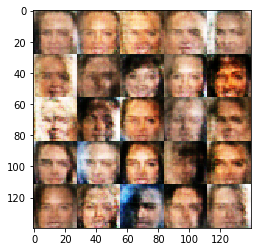

Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 1.5335
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.2022
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.3523
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.6451
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.9876


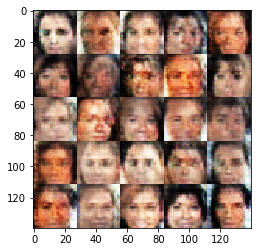

Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.1461
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 2.2326... Generator Loss: 2.4564
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 2.0010... Generator Loss: 0.2079


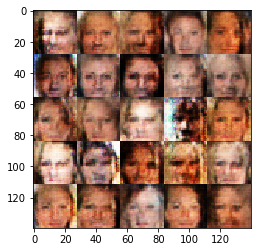

Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.7277... Generator Loss: 0.2721
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 1.7228
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.3549
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.4386
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.7402


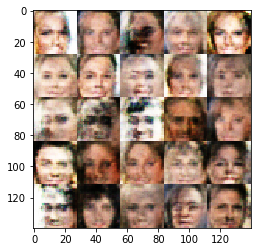

Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 2.2936... Generator Loss: 0.1606
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.4217


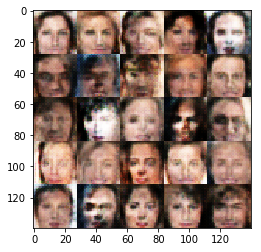

Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.4302
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.5218
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.4782
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.7767


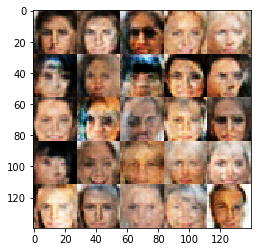

Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.4316
Epoch 1/1... Discriminator Loss: 1.8284... Generator Loss: 2.1738
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 0.9365


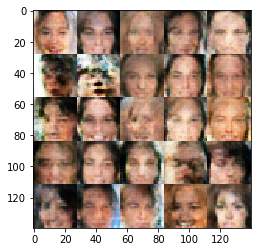

Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 1.5793
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 1.9939
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.7248


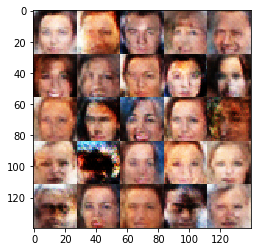

Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.7916
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.7849


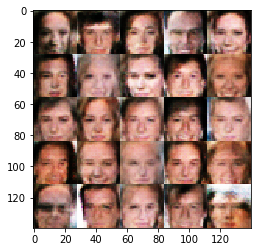

Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.3886
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.3925


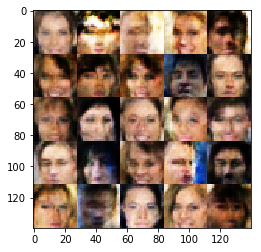

Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 1.1020


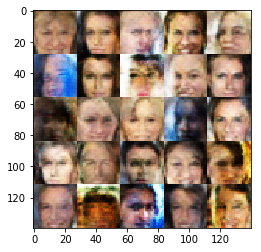

Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.8882
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.4633


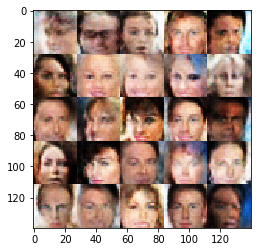

Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.3516
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.1572


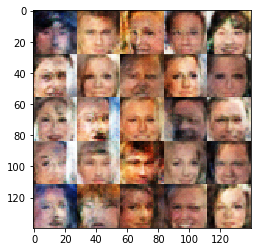

Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 1.9415
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 2.0186... Generator Loss: 0.1945
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.0390


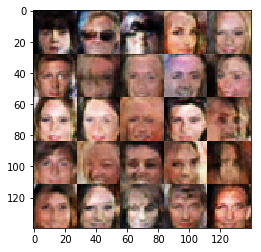

Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 2.4782
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 1.2768
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 0.3010


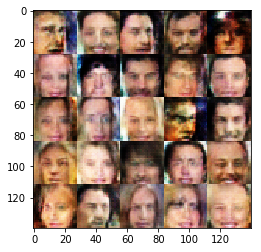

Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.6347... Generator Loss: 0.3204
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.3383
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.6963
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.6815


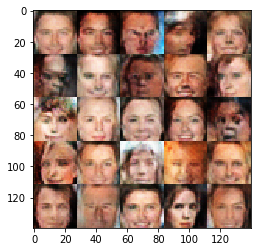

Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 1.5458
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.7033


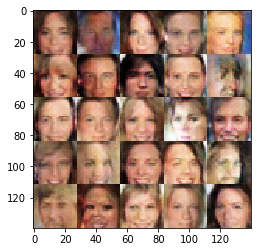

Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.6708... Generator Loss: 2.0972
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.5404


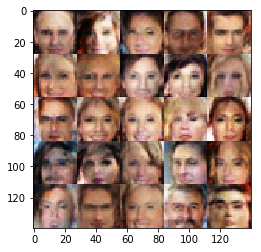

Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.8054


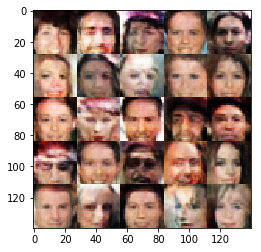

Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 1.4461
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 1.6484
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.6373


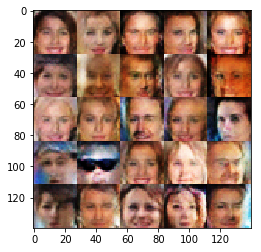

Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.2982
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.2099
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 1.6053
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 0.7094


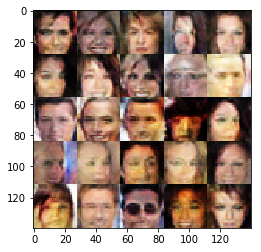

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.4269
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.6409


In [20]:
batch_size = 64
z_dim = 120
learning_rate = 0.002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.